# Simulations

Simulate some sparse data. Compare scVI, CVAE, and scanpy.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
repo_path = '/Users/mincheolkim/Github/'
data_path = '/Users/mincheolkim/Documents/'

In [3]:
import sys
sys.path.append(repo_path + 'scVI')
sys.path.append(repo_path + 'scVI-extensions')

In [4]:
import os

import numpy as np
from sklearn.manifold import TSNE
from sklearn.datasets import make_spd_matrix
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
import pandas as pd
import torch
import imp

from scvi.metrics.clustering import entropy_batch_mixing, get_latent
from scvi.models import VAE, SVAEC, VAEC
from scvi.inference import VariationalInference
from scvi.dataset import GeneExpressionDataset

/anaconda3/envs/scvi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
import scvi_extensions.dataset.supervised_data_loader as sdl
import scvi_extensions.dataset.cropseq as cs
import scvi_extensions.inference.supervised_variational_inference as svi
import scvi_extensions.hypothesis_testing.mean as mn
import scvi_extensions.models.cvae as cv

In [129]:
import scanpy.api as sc
from anndata import AnnData

### Function for generating data

In [156]:
D = 100
N = 100
NUM_TRIAL = 100

In [157]:
def generate_data(diff):
    sigma_1 = make_spd_matrix(D)
    sigma_2 = make_spd_matrix(D)
    
    means_1 = np.array([10 for i in range(D)])
    means_2 = np.array([10 for i in range(D)])
    means_2[4] = 10 + diff

    X_dense = np.concatenate([
        np.random.multivariate_normal(means_1, sigma_1, size=int(N/2)),
        np.random.multivariate_normal(means_2, sigma_2, size=int(N/2))])

    X = np.random.binomial(n=np.clip(np.round(X_dense).astype(np.int64), a_min=0, a_max=None),p=0.1)
    labels = np.array([0 for i in range(int(N/2))] + [1 for i in range(int(N/2))])
    
    dataset = GeneExpressionDataset(*GeneExpressionDataset.get_attributes_from_matrix(X, labels=labels))
    dataset.gene_names = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K'])
    
    return X_dense, dataset

### Simulation

In [114]:
imp.reload(cv)
imp.reload(svi)
imp.reload(mn)

<module 'scvi_extensions.hypothesis_testing.mean' from '/Users/mincheolkim/Github/scVI-extensions/scvi_extensions/hypothesis_testing/mean.py'>

In [153]:
n_epochs=200
lr=1e-3
use_batches=False
use_cuda=False

In [184]:
supervised_bf = []
bf = []

for diff in [1, 5, 10, 15, 20, 25, 30]:

    X_dense, gene_dataset = generate_data(diff)
    
    # Fit scVI
    vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches * use_batches, n_hidden=20, n_latent=10)
    infer = VariationalInference(
        vae, 
        gene_dataset, 
        train_size=0.9, 
        use_cuda=use_cuda,
        verbose=False,
        frequency=1)
    infer.train(n_epochs=n_epochs, lr=lr)
    
    # Fit CVAE
    cvae = cv.CVAE(gene_dataset.nb_genes, n_labels=gene_dataset.n_labels, n_batch=gene_dataset.n_batches * use_batches, n_hidden=20, n_latent=10)
    supervised_infer = svi.SupervisedVariationalInference(
        cvae, 
        gene_dataset, 
        train_size=0.9, 
        use_cuda=use_cuda,
        verbose=False,
        frequency=1)
    supervised_infer.train(n_epochs=n_epochs, lr=lr)
    
    supervised_null, supervised_de = mn.differential_expression(cvae, gene_dataset, [0,1], 100, testing=False)
    null, de = mn.differential_expression(vae, gene_dataset, [0,1], 100, testing=False)
    
    supervised_bf.append(supervised_de[0][1].query('gene == "E"')['bayes_factor_mag'].values[0])
    bf.append(de[0][1].query('gene == "E"')['bayes_factor_mag'].values[0])

training: 100%|██████████| 200/200 [00:03<00:00, 51.58it/s]
Sampling for differential expression...
Done sampling for differential expression...
Sampling for differential expression...
Done sampling for differential expression...
training: 100%|██████████| 200/200 [00:03<00:00, 55.75it/s]
Sampling for differential expression...
Done sampling for differential expression...
Sampling for differential expression...
Done sampling for differential expression...
training: 100%|██████████| 200/200 [00:04<00:00, 49.31it/s]
Sampling for differential expression...
Done sampling for differential expression...
Sampling for differential expression...
Done sampling for differential expression...
training: 100%|██████████| 200/200 [00:03<00:00, 60.21it/s]
Sampling for differential expression...
Done sampling for differential expression...
Sampling for differential expression...
Done sampling for differential expression...
training: 100%|██████████| 200/200 [00:03<00:00, 57.81it/s]
Sampling for differe

In [185]:
sns.lineplot([1, 5, 10, 15, 20, 25, 30], supervised_bf)

AttributeError: module 'seaborn' has no attribute 'lineplot'

In [180]:
de[0][1]

,gene,gene_index,P(H1),bayes_factor,bayes_factor_mag,pval,direction
3,D,3,0.3337,-0.691498,0.691498,1.916209e-149,-1.0
5,F,5,0.6432,0.589280,0.589280,0.000000e+00,1.0
4,E,4,0.3775,-0.500173,0.500173,2.212657e-82,-1.0
2,C,2,0.6038,0.421324,0.421324,0.000000e+00,1.0
8,I,8,0.3973,-0.416728,0.416728,1.119118e-58,-1.0
1,B,1,0.5607,0.244003,0.244003,0.000000e+00,1.0
9,K,9,0.4470,-0.212799,0.212799,2.871054e-17,-1.0
7,H,7,0.5506,0.203095,0.203095,4.329870e-15,1.0
0,A,0,0.4698,-0.120947,0.120947,7.152054e-07,-1.0
6,G,6,0.4773,-0.090862,0.090862,1.295665e-04,-1.0


In [181]:
supervised_de[0][1]

,gene,gene_index,P(H1),bayes_factor,bayes_factor_mag,pval,direction
0,A,0,0.7550,1.125460,1.125460,0.000000e+00,1.0
4,E,4,0.3021,-0.837318,0.837318,1.802369e-251,-1.0
3,D,3,0.3098,-0.801054,0.801054,1.742734e-232,-1.0
6,G,6,0.6895,0.797783,0.797783,0.000000e+00,1.0
8,I,8,0.3993,-0.408383,0.408383,6.675844e-67,-1.0
2,C,2,0.4011,-0.400884,0.400884,1.302488e-64,-1.0
5,F,5,0.5677,0.272473,0.272473,0.000000e+00,1.0
9,K,9,0.5627,0.252127,0.252127,0.000000e+00,1.0
7,H,7,0.5589,0.236699,0.236699,0.000000e+00,1.0
1,B,1,0.5478,0.191786,0.191786,2.220446e-16,1.0


In [130]:
adata = AnnData(gene_dataset.X)

In [146]:
adata.obs['group'] = gene_dataset.labels.reshape(-1)
adata.obs['group'] = adata.obs['group'].astype('category')

In [147]:
adata.obs.head(5)

,group
0,0
1,0
2,0
3,0
4,0


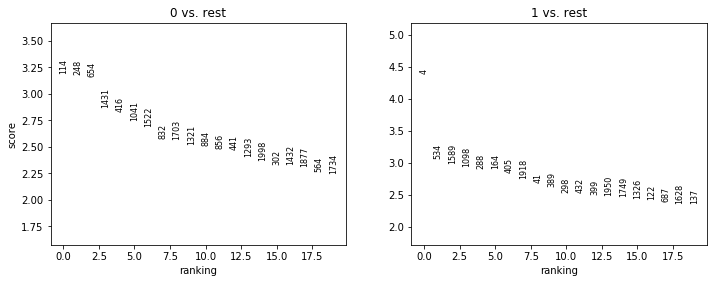

In [151]:
sc.tl.rank_genes_groups(adata, 'group')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)